 # Example of using Shap

HD Sheets,   January 2022

Updates 1/23/2024

 # Explanatory approaches in ML - Which Predictors are most effective

based on

https://www.yourdatateacher.com/2021/05/17/how-to-explain-neural-networks-using-shap/

which looks to be based on

https://shap-lrjball.readthedocs.io/en/docs_update/example_notebooks/kernel_explainer/Diabetes%20regression.html


SHaply Additive Predictors

Lloyd Shapley,   Nobel Prize 2012

The Wikipedia article on Shap values is pretty dang good


An explanation of SHAP

https://towardsdatascience.com/shap-explained-the-way-i-wish-someone-explained-it-to-me-ab81cc69ef30

In [ ]:
# Running in Google Colab

#It may be worth running this example in Google Colab,   it has some slow sections

# don't bother with turning on a GPU though

In [1]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 535.7/535.7 kB 3.2 MB/s eta 0:00:00


In [4]:
# ipywidgets

!pip install ipywidgets

# this will allow the notebook to reload/refresh automatically within the runtime
%reload_ext autoreload
%autoreload 2

import ipywidgets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 6.5 MB/s eta 0:00:00


# Load the libraries involved

Note shap was a bit fussy about Python versions,   I created a new Conda environment to run shap,  since shap wasn't compatible with
python 3.8, which was installed

also make sure you have a newer version of jupyterlab installed, and you will also need ipywidgets, make sure this is installed in jupyter prior to starting jupyter notebook, below is the command for that

jupyter nbextension enable --py widgetsnbextension


# Multiple Explainers

The Shap package has multiple ways of estimating the SHAP values, these are called explainers

The mathematics is the same,  the different explainers make use of different ways to calculate them.   Many are usable only with specific types of models, this saves time when the
calculations are carried out.

In [5]:
import shap
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import make_pipeline

from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
import numpy as np
import time
import pandas as pd
import matplotlib

The example used here is the diabetes data set from sklearn data sets

https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_diabetes.html




In [74]:
X,y = load_diabetes(return_X_y=True, as_frame=True, scaled=True)
features = load_diabetes()['feature_names']

In [75]:
features

['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6']

In [76]:
X=pd.DataFrame(X,columns=features)
X.head(3)

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204
2,0.085299,0.050680,0.044451,-0.005670,-0.045599,-0.034194,-0.032356,-0.002592,0.002861,-0.025930


Looking at the sklearn manual at

https://scikit-learn.org/stable/datasets/toy_dataset.html#diabetes-dataset

Column 11 is a quantitative measure of disease progression one year after baseline- it is a float

Here are the predictors, all of which are floats

age age in years

sex

bmi body mass index

bp average blood pressure

s1 tc, total serum cholesterol

s2 ldl, low-density lipoproteins

s3 hdl, high-density lipoproteins

s4 tch, total cholesterol / HDL

s5 ltg, possibly log of serum triglycerides level

s6 glu, blood sugar level
    


Below I used X? to find out a bit about X,   it is an ndarray, with 442 elements

In [59]:
X.iloc[0:5,]

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204
2,0.085299,0.050680,0.044451,-0.005670,-0.045599,-0.034194,-0.032356,-0.002592,0.002861,-0.025930
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022688,-0.009362
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031988,-0.046641


Let's look at y,   

In [60]:
y[0:5]

0    151.0
1     75.0
2    141.0
3    206.0
4    135.0
Name: target, dtype: float64

Next use the train_test_split() function in sklearn to set up the test and train sets,
this is really the easiest way to do this

In this case, we are using 33% of the data as the test set

In [77]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [62]:
?X_train

 # Steps in this Notebook

1.) Use Shap with a Neural Net,

2.) Use Shap with a Random Forest

3.) Use Shap with a Linear Model

4.) Use some Classic Linear Model approaches to determining which predictors are most effective, using both the sklearn
      linear models with limited results summary,  and also linear models from stats model which have more substantial ANOVA
      outputs that will allow comparison of the importances of variables from the linear model (F-tests) with shap results from
      the various models



# Using Shap with a Neural Net, and introducing pipelining

This is a pipeline structure, that allows us to easily create a function (the pipeline)

Pipeling your data preparation and the modeling process into a single pipeline is good practice,
it "bundles" data cleaning, data prep, formatting and the modeling together

It makes it very easy to apply the same processing sequence to the training and test set without looking at the test set

I wasn't seeing good convergence with only one layer of 5 neurons, I increased this to 5 and 3

max_iter was changed to 50,000 steps, these two changes improved performance

In [78]:
model = make_pipeline(
    StandardScaler(),
    MLPRegressor(hidden_layer_sizes=(5,3,),activation='relu', max_iter=50000,learning_rate='invscaling',random_state=0)
)

In [64]:
?X_train

Pipelines have fit and predict just like other sklearn models,  so their is a high level of consistency here

this fitting process will take a while,  it was around a minute on a fast machine

In [79]:
model.fit(X_train,y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('mlpregressor',
                 MLPRegressor(hidden_layer_sizes=(5, 3),
                              learning_rate='invscaling', max_iter=50000,
                              random_state=0))])

the explainer() needs ipywidgets,   make sure this is installed prior to starting jupyter notebook

jupyter nbextension enable --py widgetsnbextension

This is a function to compute accuracy, we'll use this later

In [80]:
def print_accuracy(f):
    print("Root mean squared test error = {0}".format(np.sqrt(np.mean((f(X_test) - y_test)**2))))
    time.sleep(0.5) # to let the print get out before any progress bars

In [81]:
y_pred=model.predict(X_test)

print("Root mean squared test error = {0}".format(np.sqrt(np.mean((y_pred - y_test)**2))))

Root mean squared test error = 53.53981866101771


In [82]:
# we can get the model score, this is the R^2 value
model.score(X_test,y_test)

0.5019317576052034

We will create an instance of a Shap explainer object

This is a Shap Kernel Explainer


Uses the Kernel SHAP method to explain the output of any function.

Kernel SHAP is a method that uses a special weighted linear regression to compute the importance of each feature. The computed importance values are Shapley values from game theory and also coefficents from a local linear regression.


Note:  Slightly later work indicates that not all the functions work for the KernelExplainer,   there are other explainer options, such as Exact and Permutation which may work more reliably

The next couple of cells generate warning messages, but seem to be running fine

In [83]:
explainer = shap.PermutationExplainer(model.predict,X_train)

Now we will look at how the variables contribute to the predictions in the test data set

First compute the Shap values

In [84]:
shap_values = explainer.shap_values(X_test)

In [85]:
shap_values[0:5,:]

array([[ -0.97475727,   6.05819912,  -7.70851474, -10.34537152,
        -38.5509    ,  58.02629673,  -9.05510497,  -9.96297205,
         13.98095215,  -0.74838532],
       [ 16.08460846,   5.56514336,  13.06949023,   6.34850662,
         14.46618425, -10.50090545,  -3.87802662,   8.71276017,
        -16.35345272,  -0.15103917],
       [ 12.66826671,  -9.25381887,  -8.56190574,  -9.75681801,
        -38.81951177,  11.41076722, -22.77806377,  -0.71720971,
         45.10497982,  -1.26913579],
       [ 22.64907085,   2.32122742,  29.08673302,  35.05363812,
        -23.36311602,  12.15638545,  37.98022749, -25.30789594,
         63.18049561,  -0.17631687],
       [ -2.3916523 , -13.68995101, -16.60739613,  -5.15266916,
        -15.89332108,  18.84582387,  -1.14576271,  -8.34520932,
         -5.95878028,  -0.73437324]])

# Output - A summary of Shap over the entire test data set

The High feature values are shown in Red, High values are in red,  low values are in blue

The variables at the top of the plot are the most important, those at the bottom of the plot are the least important

Looking at the plot below

High BMI increases the output, and appears to be the dominant factor in the progression of diabetes

The second most important term is sex,   low sex values increase the rate, higher decrease it.   Sex has only two values,
so it is some sort of binary coding, but we don't have a good data dictionary

S5 is a diagnostic test,

Higher age increase the progression of diabetes,  as does higher blood pressure

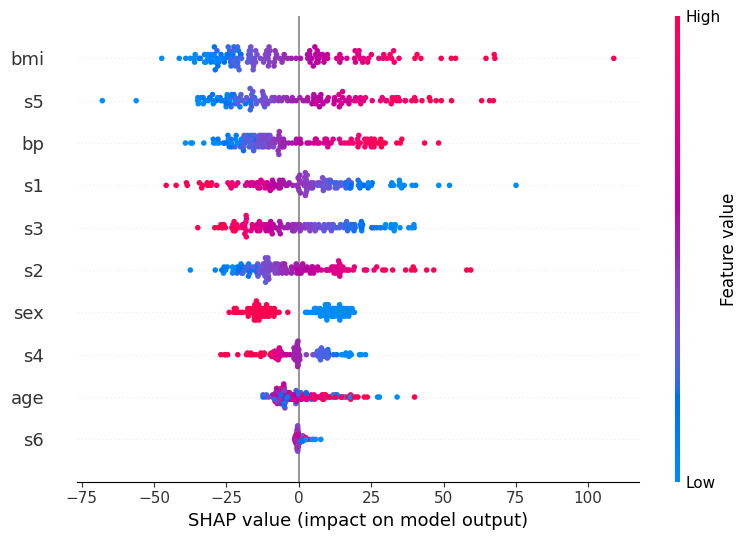

In [86]:
import matplotlib.pyplot as plt
fig=plt.figure(figsize=(10,10))

shap.summary_plot(shap_values,X_test,feature_names=features)

# Question

Based on the SHAP plot above Which variables have a positive correlation with the progression of
diabetes?

# SHAP dependence plot

This a dependence plot, it will show us the dependence of the shap value on the 2nd variable in the features list which is bmi

The help file for the dependence_plot says you can accesss this using 'bmi' instead of 2, but that's not working for some reason

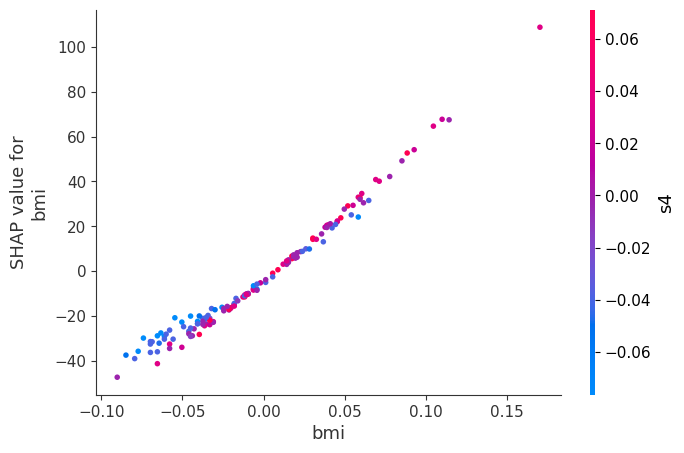

In [87]:
shap.dependence_plot(2, shap_values, X_test,feature_names=features)

# Question/Action

What should the dependence plot for s3 look like- state your prediction,  run the plot to see
if your prediction was right and then discuss why you were correct or not

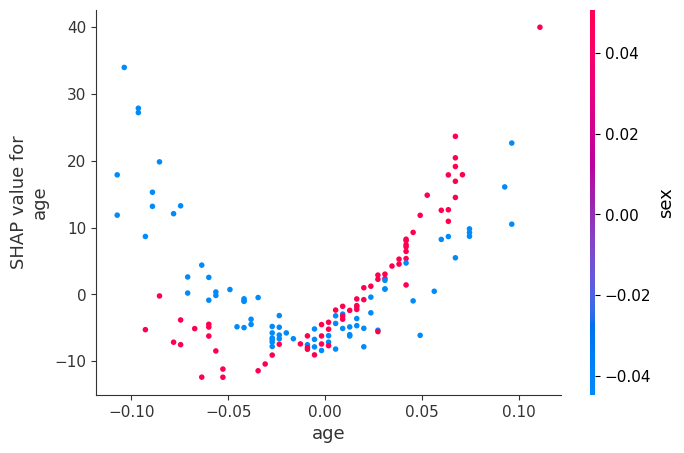

In [88]:
# here is the impact of age
shap.dependence_plot(0, shap_values, X_test,feature_names=features)

We can look at individuals as well

This is a force plot,  it shows the parameters with their values, and then a red bar for terms that increase the score
a blue bar for the terms that decrease the score

For this individual,  the progress of diabetes is increased by age, sex and s5,  and decreased by s2, a low bmi, low bp and s4

In [ ]:
help(shap.plots.force)

Help on function force in module shap.plots._force:

force(base_value, shap_values=None, features=None, feature_names=None, out_names=None, link='identity', plot_cmap='RdBu', matplotlib=False, show=True, figsize=(20, 3), ordering_keys=None, ordering_keys_time_format=None, text_rotation=0, contribution_threshold=0.05)
    Visualize the given SHAP values with an additive force layout.
    
    Parameters
    ----------
    base_value : float or shap.Explanation
        If a float is passed in, this is the reference value that the feature contributions start from.
        For SHAP values, it should be the value of ``explainer.expected_value``.
        However, it is recommended to pass in a SHAP :class:`.Explanation` object instead (``shap_values``
        is not necessary in this case).
    
    shap_values : numpy.array
        Matrix of SHAP values (# features) or (# samples x # features). If this is a
        1D array, then a single force plot will be drawn. If it is a 2D array, then 

In [89]:
expval=model.predict(X_test).mean()
expval

149.8910346717094

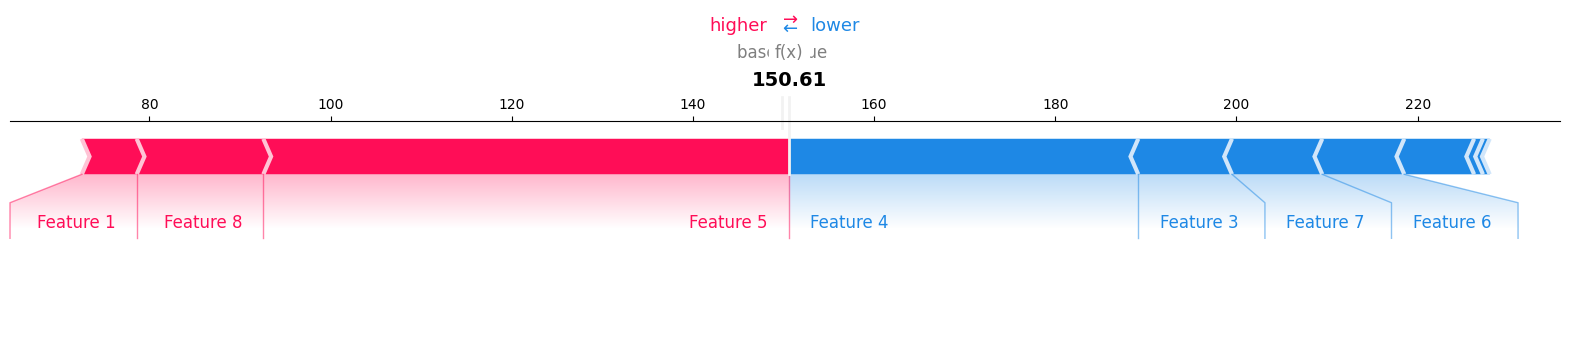

In [93]:
shap.initjs()
shap.plots.force(expval,shap_values[0,:], matplotlib=matplotlib)

Here is another individual,   in this case there are a lot of factors increasing the score

In [94]:
shap.initjs()
shap.force_plot(expval, shap_values[1,:]  ,feature_names=features)

# Alternative Shap explainers

not all the plots seem to work with the kernel explainer,  let's try a couple of other approaches,   the Exact and/or permutation explaineer

In [95]:
# this is the exact explainer-may have a long run time

explainer2= shap.explainers.Exact(model.predict,X_train)
shap_values2= explainer2(X_train)

ExactExplainer explainer: 297it [00:17,  7.60it/s]


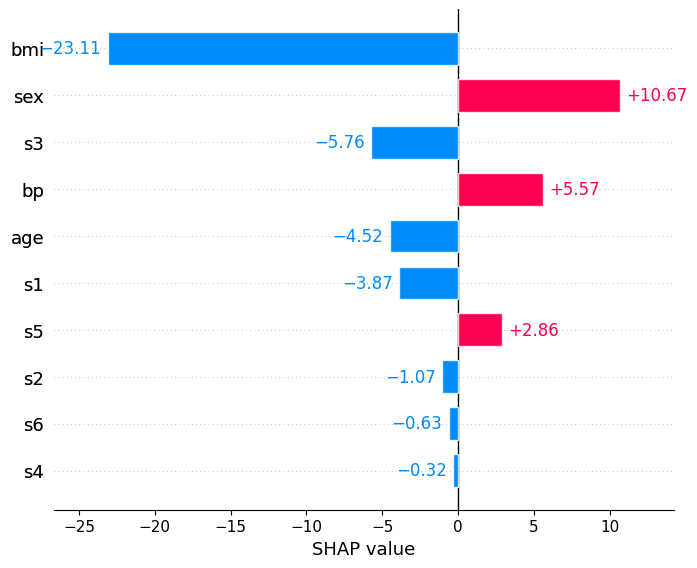

In [96]:
# this function just doesn't seem to work for the Kernel explainer
# this is the magnitude of the shap terms for an individual
shap.plots.bar(shap_values2[0,:])

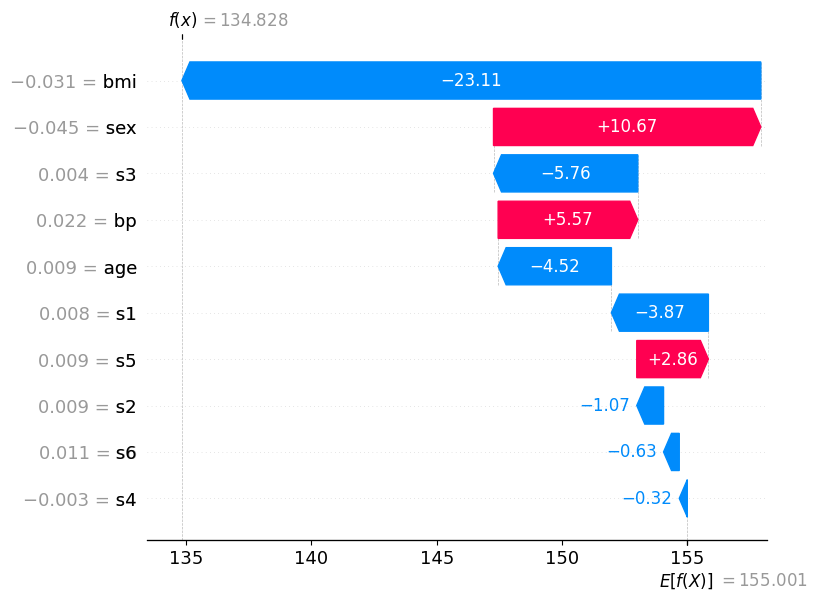

In [97]:
# this plot seems really nice for examining the behavior for individuals
shap.plots.waterfall(shap_values2[0,:])

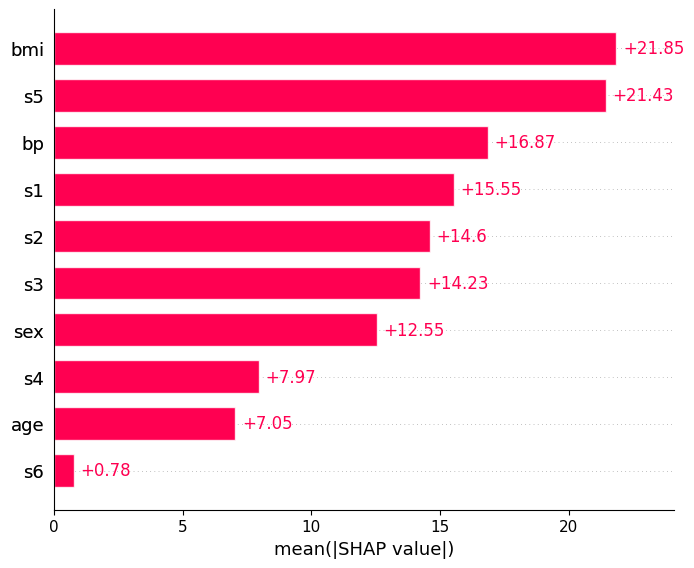

In [98]:
# mean absolute value impact of each varialble,   mean over the data set
shap.plots.bar(shap_values2)

In [100]:
# if we call the force plot with all individuals, it show us the results over the entire data set
shap.initjs()

shap.force_plot(expval, shap_values, X_test)

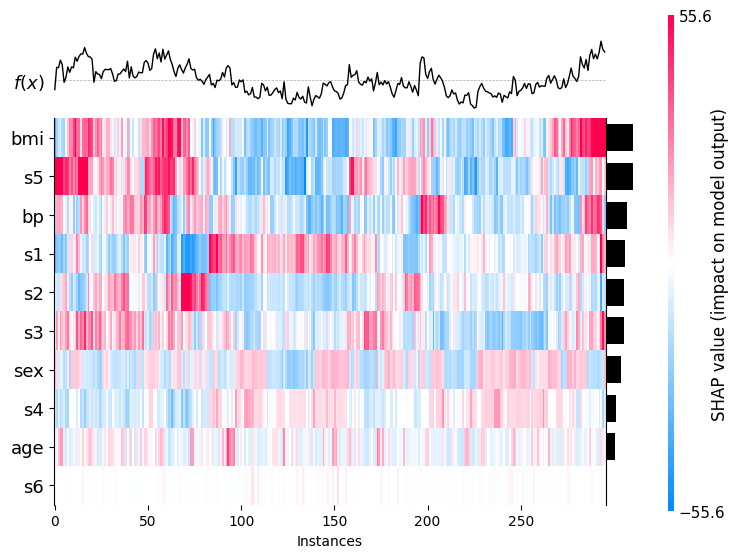

In [101]:
# the heat map is another way of showing us all the results-specimens here are clustered by their similarity to one annother,   the output magnitude
# is shown along the top edge,  specimens are plotted via similarity
shap.plots.heatmap(shap_values2)

In [ ]:
# Question,
What is indicated by the solid red block in the top line?

NOTE-  get shap waterfall plot running!

 # Using Shap with a Random Forest

 We are using a forest of 1000 trees,   each branch must have two entries

 Decision trees tend to overfit badly, so if we create 1000 trees, each trained on slightly different versions of the data and then use an average over all trees, that tends to reduce the overfitting problem.   This is an ensemble method or "wisdom of the crowd" approach.

 We will train the RF on the train data, then use a tree-explainer version of Shap and then look at the summary plot

 Uses Tree SHAP algorithms to explain the output of ensemble tree models.

Tree SHAP is a fast and exact method to estimate SHAP values for tree models and ensembles of trees, under several different possible assumptions about feature dependence. It depends on fast C++ implementations either inside an externel model package or in the local compiled C extention.


Root mean squared test error = 55.253662951843204
Score from random forest
0.4695344218420706


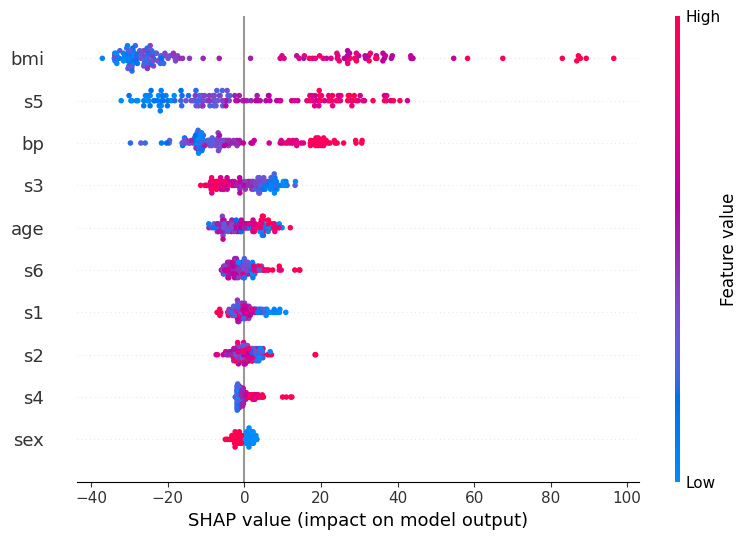

In [28]:
from sklearn.ensemble import RandomForestRegressor
from sklearn import linear_model

rforest = RandomForestRegressor(n_estimators=1000, max_depth=None, min_samples_split=2, random_state=0)
rforest.fit(X_train, y_train)
print_accuracy(rforest.predict)
print("Score from random forest")
print(rforest.score(X_test,y_test))

# explain all the predictions in the test set
explainer = shap.TreeExplainer(rforest)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test,feature_names=features)

# Question

Which of the two models here had better performance, the neural net or the random forest?
How do you know this?

For the random forest model, which predictors have a positive correlation with the outcome, and which have a negative correlation.   Did this change relative to the neural net model



The random forest is also primarily using bmi, followed by s5 and bp,  but age and sex are less important in the
tree based model.

In [102]:
# the bar plot didn't work for me here using the TreeExplainer
# there are clearly problems with some of the coding and/or storage in some explainers

shap.initjs()
shap.plots.bar(explainer)

TypeError: The shap_values argument must be an Explanation object, Cohorts object, or dictionary of Explanation objects!

In [104]:
# this cell runs slowly....
explainer3 = shap.TreeExplainer(rforest)
shap_values3 = explainer3(X_test)


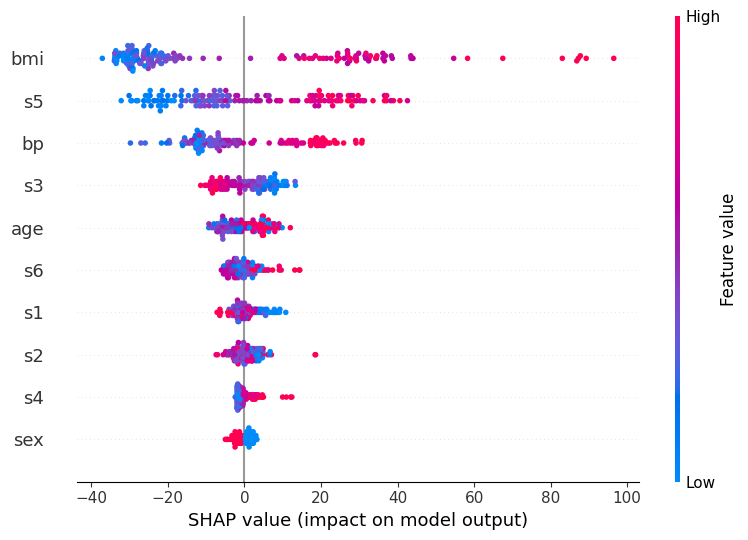

In [105]:
shap.summary_plot(shap_values3, X_test,feature_names=features)

# Question

We have just looked at SHAP values from the Exact Explainer method for the random
forest model.

How do they compare with the values from the Tree Explainer approach to SHAP value estimation for the same model?

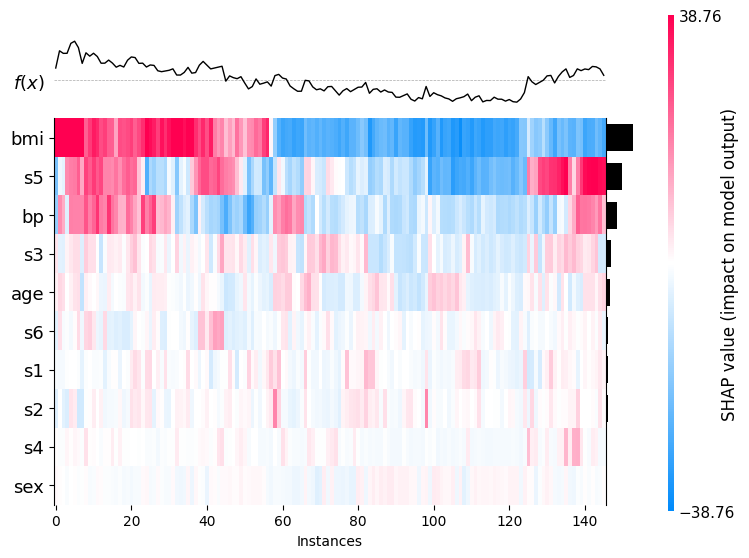

In [106]:
shap.plots.heatmap(shap_values3)

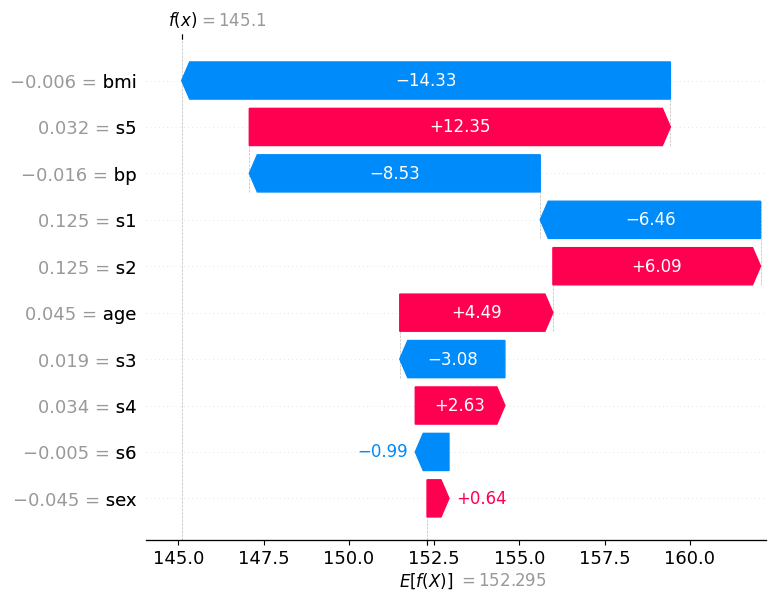

In [107]:
# this plot has not been running for me, note that in January 2024,  it worked fine...

shap.plots.waterfall(shap_values3[0,:])

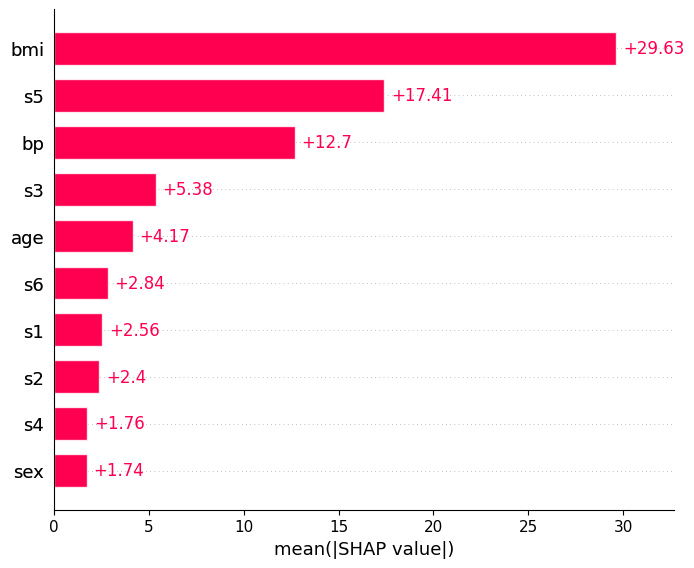

In [109]:
shap.plots.bar(shap_values3)

# Using a Linear model

Okay, let's see how a linear model does

We will build a linear model (ie a classic linear regression) first

In [110]:
from sklearn import linear_model
lin_regr = linear_model.LinearRegression()
lin_regr.fit(X_train, y_train)

print_accuracy(lin_regr.predict)
print(lin_regr.score(X_test,y_test))

Root mean squared test error = 53.08303210274997
0.5103942572821252


# Question

How is the performance of the linear model relative to the random forest and to the neural nets used earlier?

What does this mean?   In a business setting, which would you use?

Now we will use the Permutation Explainer, since it works on all classes of predictors

Initially, I had used the KernelExplainer, but that never seems to plot well

The exact explainer seems to work well, but it is painfully slow

In [111]:
ex = shap.explainers.Permutation(lin_regr.predict, X_train)
shap_values4 = ex(X_train)


PermutationExplainer explainer: 297it [00:26,  8.33it/s]


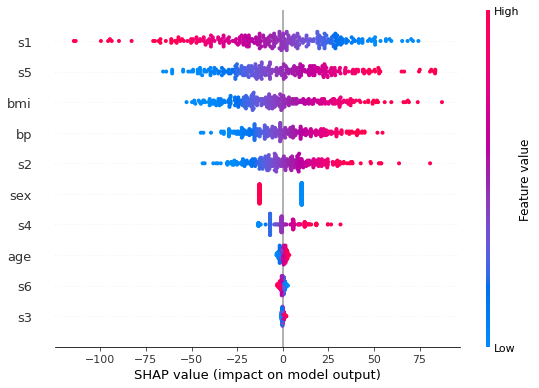

In [ ]:
shap.summary_plot(shap_values4)

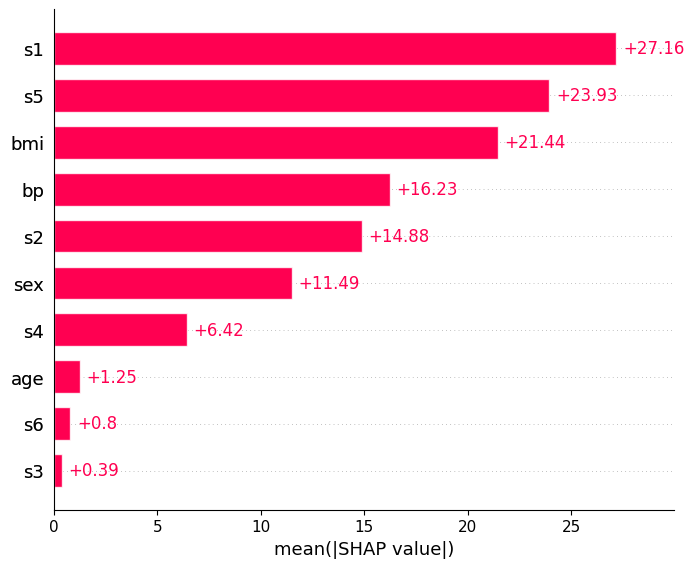

In [112]:
shap.plots.bar(shap_values4)

In [113]:
print(lin_regr.intercept_)
print(lin_regr.coef_)

150.43401223157832
[  32.14928032 -242.82449076  559.98996952  407.63766881 -718.69857577
  396.63703933   10.432395    171.81955335  627.07993787  -21.62312454]


Sklearn does not have a good summary report for the linear regression model,  the summaries from R or Sas are far better.

It turns out that sklearn really focuses on prediction only,  you really need to use other tools (like Shap) to understand
model structures, or variable importance.

There are a bunch of tools for cross validation and a bunch of performance metrics to help assess models in sklearn,  but it
just doesn't have the same kind of detailed tools for working with linear models

We could go back and use R, or Sas,  or we could use the statsmod library in Python

 # Classic Linear model evaluation with statsmodel

 https://www.statsmodels.org/stable/regression.html

 We are using this here since statsmod has more detailed reports

In [114]:
import statsmodels.api as sm

# we need to put the training dat into a data frame,  and a constant value to the data frame to handle the intercept term

X_train2=X_train.copy()
X_train2=sm.add_constant(X_train2, prepend=False)

X_train2=pd.DataFrame(X_train2)
temp=features.copy()
temp.append("constant")

X_train2.columns=temp

# create an instance of the linear model,  of type Ordinary Least Square OLS

mod_lin=sm.OLS(y_train,X_train2)

# fit the model

res_lin=mod_lin.fit()

# print the summaruy table

print(res_lin.summary())


                            OLS Regression Results                            
Dep. Variable:                 target   R-squared:                       0.510
Model:                            OLS   Adj. R-squared:                  0.493
Method:                 Least Squares   F-statistic:                     29.63
Date:                Fri, 26 Jan 2024   Prob (F-statistic):           9.78e-39
Time:                        17:09:14   Log-Likelihood:                -1602.4
No. Observations:                 296   AIC:                             3227.
Df Residuals:                     285   BIC:                             3267.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
age           32.1493     76.323      0.421      0.6

This summary doesn't give us the F-test values,  

F-tests are basically the variance explained by a predictor divided by the error variance per degree of freedom.

So F-test values are a measure of the variance explained by each term.

There are a lot of problems with estimating F values when the predictor variables are correlated, as they
probably are here.   Note that Shap goes to great lenghths to understand how each variable contributes indepent
of the others,   which is a big advantage relative to the F-tests.

It turns out that statsmod has several different ways of working with ordinary least squares linear regression.

In the OLS routine above,   we enter the predictors and response as separate inputs

There is another routine ols (lower case, sigh) that uses a dataframe and a formula,  just like the R version

below is the setup for using the ols() function that gives us F-values

In [115]:
# set up for other version of ols in statsmodel, the version driven by a stated model

X_train2['y']=y_train

In [116]:
from statsmodels.formula.api import ols

formula2='X_train2.y~X_train2.age+X_train2.sex+X_train2.bmi+X_train2.bp+X_train2.s1+X_train2.s2+X_train2.s3+X_train2.s4+X_train2.s5+X_train2.s5+X_train2.constant'

mod_lin2=ols(formula2,X_train2).fit()

table = sm.stats.anova_lm(mod_lin2, typ=2) # Type 2 ANOVA DataFrame

print(table)

                          sum_sq     df          F        PR(>F)
X_train2.age          477.168859    1.0   0.156286  6.928937e-01
X_train2.sex        31424.035709    1.0  10.292251  1.487710e-03
X_train2.bmi       135668.492994    1.0  44.435228  1.351556e-10
X_train2.bp         82540.454629    1.0  27.034309  3.812436e-07
X_train2.s1          6603.573501    1.0   2.162855  1.424811e-01
X_train2.s2          3089.635007    1.0   1.011942  3.152884e-01
X_train2.s3             5.430128    1.0   0.001779  9.663906e-01
X_train2.s4          2139.751889    1.0   0.700829  4.032044e-01
X_train2.s5         27060.499177    1.0   8.863071  3.158962e-03
X_train2.constant       5.642465    1.0   0.001848  9.657402e-01
Residual           873207.835815  286.0        NaN           NaN


In [ ]:
# Question

Fill in the table below

Variable importance      1        2        3       4         5     6        7       8        9
Linear model (Shap)
Linear model (F val)    BMI      bp       sex      s5       s1     s2      s4       s4       age
Neural net (Shap)
RF (Shap)

# Summary of Results

What variables were important in the different models?  Are the models consistent about which variables are good predictors?




 # Why so many slightly different results
    
The main issue here is that the predictor variables in X-test are correlated with one another, so they are
not independent predictors.  There are many ways to build models that work reasonably well when the predictors
are correlated, the higher the correlation of predictors, the more difficult it is to figure out
which are the most influential predictors

We should look at the correlation structure of the predictor variables

In [117]:
# I want to use a pd DataFrame, so I can add the column labels
X_train2=X_train.copy()

X_train2=pd.DataFrame(X_train2)
X_train2.columns=features.copy()

my_corr=X_train2.corr()

my_corr

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
age,1.000000,0.158365,0.154118,0.296175,0.256847,0.199423,-0.027358,0.167114,0.265242,0.271433
sex,0.158365,1.000000,0.064689,0.179566,0.039423,0.134719,-0.350479,0.339617,0.129306,0.174451
bmi,0.154118,0.064689,1.000000,0.377067,0.237922,0.255167,-0.378082,0.434438,0.439079,0.390869
bp,0.296175,0.179566,0.377067,1.000000,0.239817,0.165235,-0.110201,0.212675,0.353409,0.386687
s1,0.256847,0.039423,0.237922,0.239817,1.000000,0.887722,0.060949,0.547016,0.522204,0.315614
s2,0.199423,0.134719,0.255167,0.165235,0.887722,1.000000,-0.181797,0.646648,0.294901,0.282576
s3,-0.027358,-0.350479,-0.378082,-0.110201,0.060949,-0.181797,1.000000,-0.729197,-0.373460,-0.280956
s4,0.167114,0.339617,0.434438,0.212675,0.547016,0.646648,-0.729197,1.000000,0.619194,0.413076
s5,0.265242,0.129306,0.439079,0.353409,0.522204,0.294901,-0.373460,0.619194,1.000000,0.456700
s6,0.271433,0.174451,0.390869,0.386687,0.315614,0.282576,-0.280956,0.413076,0.456700,1.000000


<Axes: >

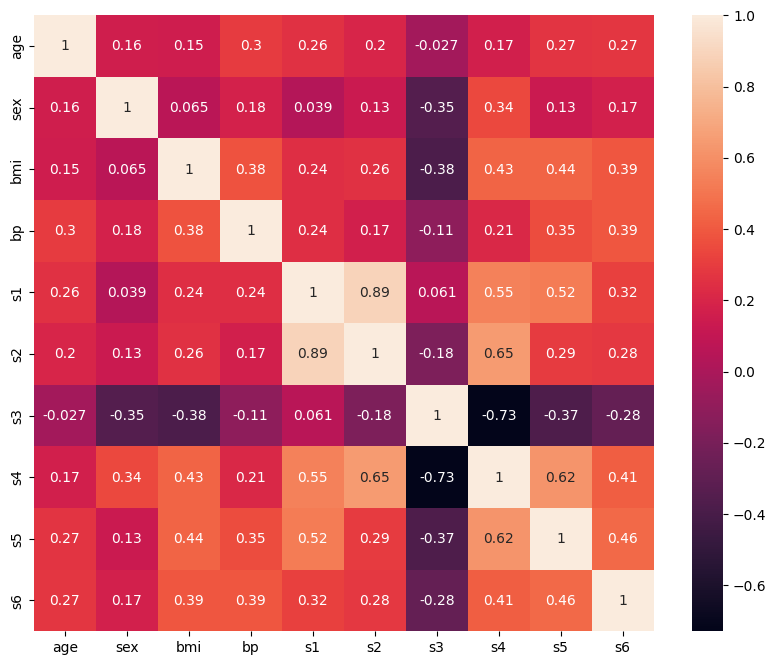

In [118]:
# the seaborn package has a heatmap so we can display this
import seaborn as sns
matplotlib.pyplot.figure(figsize=(10, 8))
# plot the heatmap
sns.heatmap(my_corr,
        xticklabels=my_corr.columns,
        yticklabels=my_corr.columns,annot=True)

Let's use a PCA to estimate how many statistically independent variables are present in the 10

The number of "meaningful"  PCA axis is basically the number of distinct independent "factors" we have among the 10 variables.

In [120]:
from sklearn.decomposition import PCA

my_pca=PCA()

my_pca.fit(X_train2)

print(my_pca.explained_variance_ratio_)

[0.39293971 0.14971491 0.12472338 0.0985693  0.06788862 0.05852574
 0.05426334 0.0444657  0.00792515 0.00098414]


In looking at the PCA results, we have 10 distinct axes for 10 variables

The first 7 each explain 5% or more of the total variance in X_train,  the 8th explains 4.4%,  and the last two explain
basically nothing,  so we have 2 redudant variables in the predictors,   that's actually not many out of 10, so there is
lot of independence in these variables


